# **Phân loại tin tức tiếng Việt sử dụng SVM**

## 1. Xác định bài toán

- Đầu vào bài toán: 1 đoạn tin tức tiếng Việt  
- Đầu ra: Lớp tương ứng với đoạn tin tức đó

- Dataset: VNews8td  
- Mô tả:  Được thu thập từ trang báo mạng VnExpress từ ngày 01/06/2023 - 01/06/2024. Gồm 8 lớplớp, chia train:val:test theo tỉ lệ 70:10:20. Mỗi văn bản sẽ gồm có tiêu đề và phần mô tả của bài báo  
- 8 lớp: 	
    * doisong (Đời sống)
	* giaoduc (Giáo dục)
	* khoahoc (Khoa học)
	* kinhte (Kinh tế)
	* suckhoe (Sức khỏe)
	* thegioi (Thế giới)
	* thethao (Thể thao)
	* thoisu (Thời sự)

### Import thư viện 

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyvi import ViTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
from sklearn.metrics import classification_report

## 2. Tiền xử lý dữ liệu

In [9]:
train_df = pd.read_csv("VNews8td/train.tsv", sep='\t',header=None, names=['văn bản','lớp'])
test_df = pd.read_csv("VNews8td/test.tsv", sep='\t',header=None, names=['văn bản','lớp'])
val_df = pd.read_csv("VNews8td/val.tsv", sep='\t',header=None, names=['văn bản','lớp'])

In [12]:
print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(31745, 2)
(9115, 2)
(4490, 2)


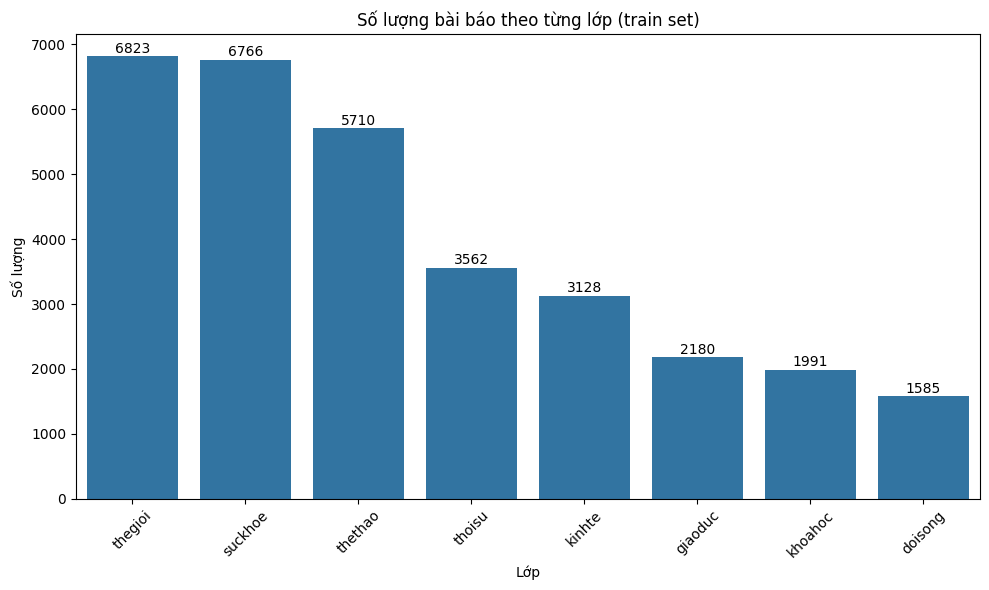

In [16]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=train_df, x='lớp', order=train_df['lớp'].value_counts().index)

plt.title('Số lượng bài báo theo từng lớp (train set)')
plt.xlabel('Lớp')
plt.ylabel('Số lượng')
plt.xticks(rotation=45)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2, height + 5,  
            f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

Dữ liệu bị mất cân bằng giữa các lớp --> dùng class weighted, hoặc augment data 

In [25]:
tokens = ViTokenizer.tokenize(train_df['văn bản'][0]).split()
print(tokens)

['Ba_Lan', 'sa_thải', 'HLV', 'Santos', 'sau', 'sáu', 'trận', '.', 'Liên_đoàn', 'Bóng_đá', 'Ba_Lan', 'quyết_định', 'chia_tay', 'HLV', 'Fernando_Santos', ',', 'người', 'từng', 'đưa', 'Bồ_Đào_Nha', 'đến', 'chức', 'vô_địch', 'Euro', '2016', '.']


In [38]:
with open('vietnamese_stopwords.txt', 'r', encoding='utf-8') as f:
    stopwords = list(line.strip() for line in f)

def remove_stopwords(text):
    tokens = ViTokenizer.tokenize(text).split()
    filtered_tokens = [t for t in tokens if t not in stopwords]
    return ' '.join(filtered_tokens)

txt = remove_stopwords(train_df['văn bản'][0])
print(txt)

Ba_Lan sa_thải HLV Santos sáu trận . Liên_đoàn Bóng_đá Ba_Lan quyết_định chia_tay HLV Fernando_Santos , Bồ_Đào_Nha chức vô_địch Euro 2016 .


In [40]:
print("Danh sách 10 từ dừng đầu tiên (từ không mang ý nghĩa phân loại): ", stopwords[0:10])

Danh sách 10 từ dừng đầu tiên (từ không mang ý nghĩa phân loại):  ['a_lô', 'a_ha', 'ai', 'ai_ai', 'ai_nấy', 'ai_đó', 'alô', 'amen', 'anh', 'anh_ấy']


Chuyển dữ liệu từ dạng văn bản về dạng số để xử lý 

In [41]:
vectorizer = TfidfVectorizer(stop_words=stopwords)
X_train = vectorizer.fit_transform(train_df['văn bản'])
X_val = vectorizer.transform(val_df['văn bản'])
X_test = vectorizer.transform(test_df['văn bản'])


In [45]:
le = LabelEncoder()
y_train = le.fit_transform(train_df['lớp'])
y_val = le.transform(val_df['lớp'])
y_test = le.transform(test_df['lớp'])

In [49]:
print(le.classes_)

['doisong' 'giaoduc' 'khoahoc' 'kinhte' 'suckhoe' 'thegioi' 'thethao'
 'thoisu']


In [51]:
print("Dữ liệu training: ", X_train.shape, y_train.shape)
print("Dữ liệu validation: ", X_val.shape, y_val.shape)
print("Dữ liệu testing: ", X_test.shape, y_test.shape)


Dữ liệu training:  (31745, 15165) (31745,)
Dữ liệu validation:  (4490, 15165) (4490,)
Dữ liệu testing:  (9115, 15165) (9115,)


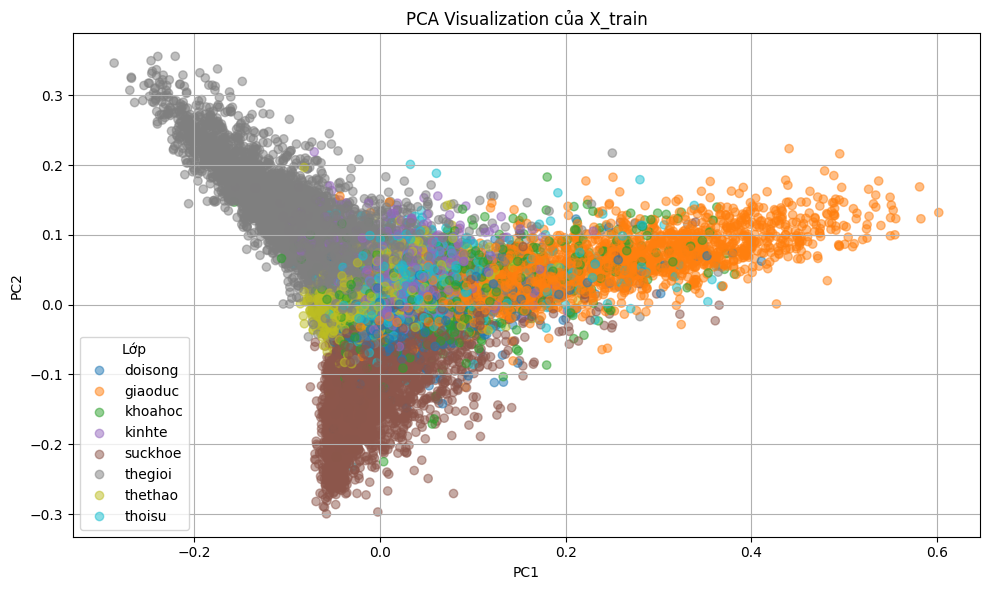

In [50]:
from sklearn.decomposition import PCA

# Giảm chiều TF-IDF về 2D
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_train.toarray()) 

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_train, cmap='tab10', alpha=0.5)
handles, indices = scatter.legend_elements()
labels = le.classes_ 

plt.legend(handles, labels, title="Lớp")
plt.title("PCA Visualization của X_train")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()


Dữ liệu không linear, bị chồng chéo lên nhau --> nếu dùng kernel = 'linear' có thể không đạt được hiệu quả cao bằng 

## 3. Huấn luyện mô hình & đánh giá mô hình

*Lưu ý: Đánh giá trên tập validation*

In [53]:
print("- Training ...")
print("- Train size = {}".format(X_train.shape))
model = svm.SVC(kernel='linear', C=1)
model.fit(X_train, y_train)
print("- model - train complete")

- Training ...
- Train size = (31745, 15165)
- model - train complete


In [ ]:
print("- Testing ...")
y_val_pred = model.predict(X_val)
y_train_pred = model.predict(X_train)

print("\n Classification Report (Validation Set):")
print(classification_report(y_val, y_val_pred, target_names=le.classes_))

print("\n Classification Report (Train Set):")
print(classification_report(y_train, y_train_pred, target_names=le.classes_))


- Testing ...


## 4. Tối ưu tham số

*Lưu ý: tối ưu tham số trên tập validation, sau đó cuối cùng lấy tham số tốt nhất đánh giá cho tập test* 

## 5. Tài liệu tham khảo

- Dataset: https://www.kaggle.com/datasets/dat111/xlnntn-th-lab08
- Vietnamese stopwords: https://github.com/stopwords/vietnamese-stopwords  
- Thư viện preprocessing tiếng Việt: pyvi - https://pypi.org/project/pyvi/